<a href="https://colab.research.google.com/github/mushrafi88/MSE_510/blob/main/hackathon_problems_Mushrafi_Munim_Sushmit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushrafi Munim Sushmit

- Here there are four Hackathon problems prepared by Richard (Yu) Liu and Sergei Kalinin.
- Please select **2** out of **4** problems for your in-class "mini-hackathon".

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


# Q-1: Interpolating a Sparse Phase Diagram

**Problem description:**

This is a simulated 2D phase diagram: the measured property of (bandgap, coercive field, ionic conductivity, etc.) as a function of parameters (temperature, composition, pressure, etc.).

The property itself is continuous in the phase diagram, but its 1st-derivative is discontinuous at the phase boundaries.

**Tasks:**

1. Using ChatGPT and your domain knowledge, suggest the domain in parameter space over which the function is defined.
2. Using ChatGPT and your domain knowledge, estimate how the function can behave across the parameter space (continuity, extrema, behavior at the edges)
3. Interpolate the property over the full composition space.
4. Compare at least two interpolation methods (e.g., linear, cubic, radial basis).
5. Quantify interpolation uncertainty using cross-validation.
6. Compare uncertainty to the mean square error



In [ ]:
# Measured (p1, p2) parameter pairs
xy = np.array([[0.77395605, 0.43887844],
       [0.85859792, 0.69736803],
       [0.09417735, 0.97562235],
       [0.7611397 , 0.78606431],
       [0.12811363, 0.45038594],
       [0.37079802, 0.92676499],
       [0.64386512, 0.82276161],
       [0.4434142 , 0.22723872],
       [0.55458479, 0.06381726],
       [0.82763117, 0.6316644 ],
       [0.75808774, 0.35452597],
       [0.97069802, 0.89312112],
       [0.7783835 , 0.19463871],
       [0.466721  , 0.04380377],
       [0.15428949, 0.68304895],
       [0.74476216, 0.96750973],
       [0.32582536, 0.37045971],
       [0.46955581, 0.18947136],
       [0.12992151, 0.47570493],
       [0.22690935, 0.66981399],
       [0.43715192, 0.8326782 ],
       [0.7002651 , 0.31236664],
       [0.8322598 , 0.80476436],
       [0.38747838, 0.2883281 ],
       [0.6824955 , 0.13975248],
       [0.1999082 , 0.00736227],
       [0.78692438, 0.66485086],
       [0.70516538, 0.78072903],
       [0.45891578, 0.5687412 ],
       [0.139797  , 0.11453007],
       [0.66840296, 0.47109621],
       [0.56523611, 0.76499886],
       [0.63471832, 0.5535794 ],
       [0.55920716, 0.3039501 ],
       [0.03081783, 0.43671739]])

In [ ]:
# # Measured properties corresponding to the parameter pairs above

P_meas = np.array([3.12767655, 2.69646584, 2.06816235, 2.04820471, 1.41774581,
       3.04612474, 2.53364197, 2.34977995, 1.85446029, 2.87615438,
       2.79939622, 2.85913196, 2.36494563, 1.84774248, 1.96575226,
       2.37555217, 1.43091456, 2.27810839, 1.54323973, 2.12702863,
       2.79308942, 2.48750609, 3.07641066, 1.92720037, 1.84069555,
       2.14516326, 1.93443675, 1.85282274, 1.56231561, 1.68040985,
       2.65628142, 2.01911448, 2.23605819, 2.73677409, 1.66478083])

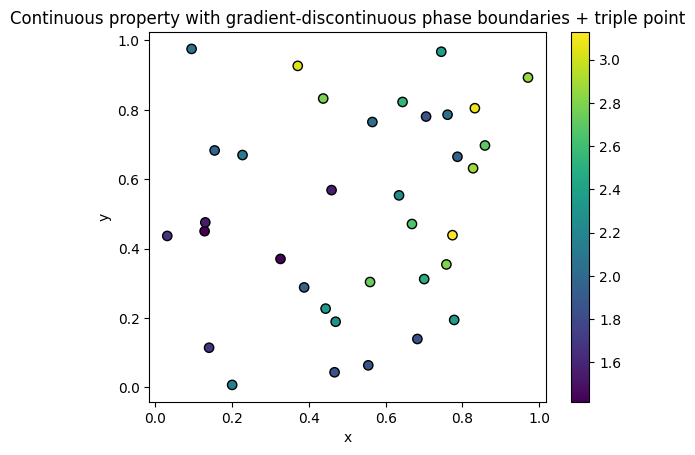

In [ ]:
# Visualization of the measurement with noise:

plt.scatter(xy[:,0], xy[:,1], c=P_meas, edgecolors="k", s=45)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Continuous property with gradient-discontinuous phase boundaries + triple point")
plt.colorbar()
plt.show()

## Ground truth for benchmarking and validation.

In [ ]:
import numpy as np

# ----------------------------
# Smooth background property P0
# ----------------------------
def P0(x, y):
    """
    Smooth base landscape so the property varies continuously across the whole diagram.
    """
    return (
        1.2
        + 0.9*x
        + 0.7*y
        + 0.25*np.sin(2*np.pi*x)*np.cos(2*np.pi*y)
        + 0.15*np.exp(-((x-0.25)**2 + (y-0.75)**2)/0.02)
    )

# ----------------------------
# Triple-point construction via max of 3 planes
# ----------------------------
def triple_planes(x, y, x0=0.55, y0=0.52, scale=0.9):
    """
    Three affine functions f1,f2,f3 that all equal 0 at (x0,y0).
    Their max partitions the plane into 3 sectors meeting at the triple point.
    """
    u = x - x0
    v = y - y0

    # 3 directions separated by 120 degrees
    a1 = np.array([ 1.0,  0.0])
    a2 = np.array([-0.5,  np.sqrt(3)/2])
    a3 = np.array([-0.5, -np.sqrt(3)/2])

    f1 = scale * (a1[0]*u + a1[1]*v)
    f2 = scale * (a2[0]*u + a2[1]*v)
    f3 = scale * (a3[0]*u + a3[1]*v)
    return f1, f2, f3

def P_ground_truth(x, y, x0=0.55, y0=0.52):
    """
    Continuous property with 3-phase triple point at (x0,y0).
    Gradient is discontinuous across the phase boundaries (where argmax switches).
    """
    f1, f2, f3 = triple_planes(x, y, x0=x0, y0=y0, scale=0.9)

    # max-of-three gives 3 regions with kinked boundaries
    kink = np.maximum.reduce([f1, f2, f3])
    # return kink
    return P0(x, y) + kink

# ----------------------------
# Phase labeling (optional, useful for grading / visualization)
# ----------------------------
def phase_id(x, y, x0=0.55, y0=0.52):
    """
    Returns 0/1/2 indicating which plane wins the max (phase region).
    """
    f1, f2, f3 = triple_planes(x, y, x0=x0, y0=y0, scale=0.9)
    F = np.stack([f1, f2, f3], axis=-1)
    return np.argmax(F, axis=-1)

# ----------------------------
# Random sampling + LogNormal noise
# ----------------------------
def sample_measurements(n=35, sigma_ln=0.15, seed=0, x0=0.55, y0=0.52):
    """
    Random (x,y) ~ Uniform([0,1]^2).
    LogNormal multiplicative noise: P_meas = P_true * LogNormal(0, sigma_ln).
    """
    rng = np.random.default_rng(seed)
    xy = rng.uniform(0.0, 1.0, size=(n, 2))
    x, y = xy[:, 0], xy[:, 1]

    P_true = P_ground_truth(x, y, x0=x0, y0=y0)

    # median 1 multiplicative noise
    noise_factor = rng.lognormal(mean=0.0, sigma=sigma_ln, size=n)
    P_meas = P_true * noise_factor

    return xy, P_true, P_meas

# Example usage:
if __name__ == "__main__":
    xy, P_true, P_meas = sample_measurements(n=35, sigma_ln=0.20, seed=42)
    print("First 5 samples:")
    for i in range(5):
        print(f"(x,y)=({xy[i,0]:.3f},{xy[i,1]:.3f})  true={P_true[i]:.4f}  meas={P_meas[i]:.4f}")


First 5 samples:
(x,y)=(0.774,0.439)  true=2.6345  meas=3.1277
(x,y)=(0.859,0.697)  true=2.8016  meas=2.6965
(x,y)=(0.094,0.976)  true=2.6693  meas=2.0682
(x,y)=(0.761,0.786)  true=2.5693  meas=2.0482
(x,y)=(0.128,0.450)  true=1.7040  meas=1.4177


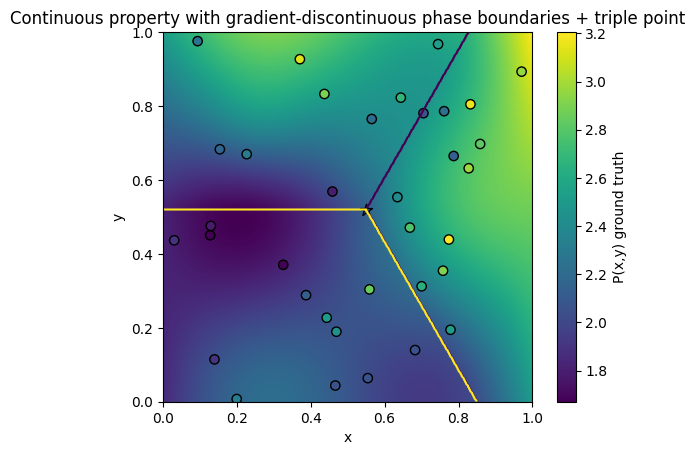

In [ ]:
import matplotlib.pyplot as plt

res = 350
xs = np.linspace(0, 1, res)
ys = np.linspace(0, 1, res)
X, Y = np.meshgrid(xs, ys)

Z = P_ground_truth(X, Y, x0=0.55, y0=0.52)
PID = phase_id(X, Y, x0=0.55, y0=0.52)

xy, P_true, P_meas = sample_measurements(n=35, sigma_ln=0.20, seed=42, x0=0.55, y0=0.52)

plt.figure()
plt.imshow(Z, origin="lower", extent=[0,1,0,1], aspect="equal")
plt.colorbar(label="P(x,y) ground truth")

# Phase boundaries are where phase_id changes; contour those boundaries
plt.contour(X, Y, PID, levels=[0.5, 1.5], linewidths=1.5)

# Mark triple point
plt.scatter([0.55], [0.52], s=80, marker="*", edgecolors="k")

# Samples colored by measured value
plt.scatter(xy[:,0], xy[:,1], c=P_meas, edgecolors="k", s=45)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Continuous property with gradient-discontinuous phase boundaries + triple point")
plt.show()


# Q-2: Root-Finding in Nonlinear Constitutive Models

**Problem description:**

A nonlinear stress–strain relation is given implicitly:

$\sigma = E\epsilon + \alpha \cdot \epsilon ^ 3$

where $\sigma$ is the stress, $\epsilon$ is the strain, $E$ is the Young’s modulus (doimnate at small strain), and $\alpha$ is cubic nonlinear term (leading-order elastic nonlinearity).

For typical soft polymers, $E$ $\approx 10^4$ to $10 ^7$ Pa, and $\alpha$ $\approx 10^6$ to $10^8$ Pa

**Tasks:**

1. Given stress values $\sigma$, solve for strain $\epsilon$.
2. Compare Newton, bisection, and secant methods.
3. Identify regimes where Newton fails.




 Find strain for stress function codes

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for a typical soft polymer
E = 1e5       # Young's modulus (Pa)
alpha = 1e7   # Nonlinear term (Pa)
sigma_target = 5e4  # The stress value we want to solve for

def f(epsilon):
    return alpha * epsilon**3 + E * epsilon - sigma_target

def df(epsilon):
    return 3 * alpha * epsilon**2 + E

# 1. Bisection Method
def bisection(a, b, tol=1e-6):
    iters = 0
    while (b - a) / 2 > tol:
        midpoint = (a + b) / 2
        if f(midpoint) == 0:
            return midpoint, iters
        elif f(a) * f(midpoint) < 0:
            b = midpoint
        else:
            a = midpoint
        iters += 1
    return (a + b) / 2, iters

# 2. Newton-Raphson Method
def newton(x0, tol=1e-6, max_iter=100):
    x = x0
    for i in range(max_iter):
        fx = f(x)
        dfx = df(x)
        if abs(fx) < tol:
            return x, i
        x = x - fx / dfx
    return x, max_iter

# 3. Secant Method
def secant(x0, x1, tol=1e-6, max_iter=100):
    for i in range(max_iter):
        f0, f1 = f(x0), f(x1)
        if abs(f1 - f0) < 1e-12: break
        x_next = x1 - f1 * (x1 - x0) / (f1 - f0)
        if abs(x_next - x1) < tol:
            return x_next, i
        x0, x1 = x1, x_next
    return x1, max_iter

# Solve
sol_bis, it_bis = bisection(0, 1.0)
sol_new, it_new = newton(0.5)
sol_sec, it_sec = secant(0, 0.5)

print(f"Bisection: {sol_bis:.6f} ({it_bis} iters)")
print(f"Newton:    {sol_new:.6f} ({it_new} iters)")
print(f"Secant:    {sol_sec:.6f} ({it_sec} iters)")

Bisection: 0.151599 (19 iters)
Newton:    0.151598 (7 iters)
Secant:    0.151598 (12 iters)


heatmap of the models over a region

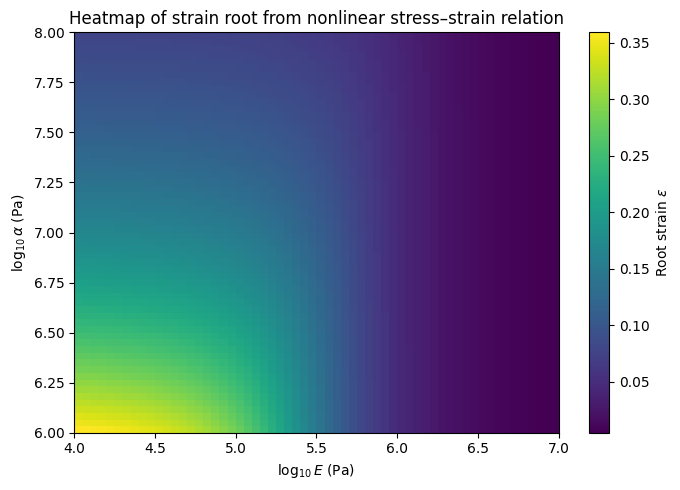

In [2]:
# Heatmap of strain roots epsilon as a function of E and alpha
import numpy as np
import matplotlib.pyplot as plt

# Fixed target stress
sigma_target = 5e4

# Parameter ranges (log-spaced)
E_vals = np.logspace(4, 7, 60)        # Young's modulus
alpha_vals = np.logspace(6, 8, 60)    # Nonlinear coefficient

# Define f and df (depend on E, alpha)
def f_eps(eps, E, alpha):
    return alpha * eps**3 + E * eps - sigma_target

def df_eps(eps, E, alpha):
    return 3 * alpha * eps**2 + E

# Newton method for root finding
def newton_root(E, alpha, x0=0.1, tol=1e-6, max_iter=100):
    x = x0
    for _ in range(max_iter):
        fx = f_eps(x, E, alpha)
        dfx = df_eps(x, E, alpha)
        if abs(fx) < tol:
            return x
        x = x - fx / dfx
    return np.nan

# Compute roots
eps_roots = np.zeros((len(alpha_vals), len(E_vals)))

for i, alpha in enumerate(alpha_vals):
    for j, E in enumerate(E_vals):
        eps_roots[i, j] = newton_root(E, alpha)

# Plot heatmap
plt.figure(figsize=(7, 5))
plt.imshow(
    eps_roots,
    extent=[np.log10(E_vals[0]), np.log10(E_vals[-1]),
            np.log10(alpha_vals[0]), np.log10(alpha_vals[-1])],
    origin="lower",
    aspect="auto"
)
plt.colorbar(label=r"Root strain $\epsilon$")
plt.xlabel(r"$\log_{10} E$ (Pa)")
plt.ylabel(r"$\log_{10} \alpha$ (Pa)")
plt.title("Heatmap of strain root from nonlinear stress–strain relation")
plt.tight_layout()
plt.show()


which model is better ?

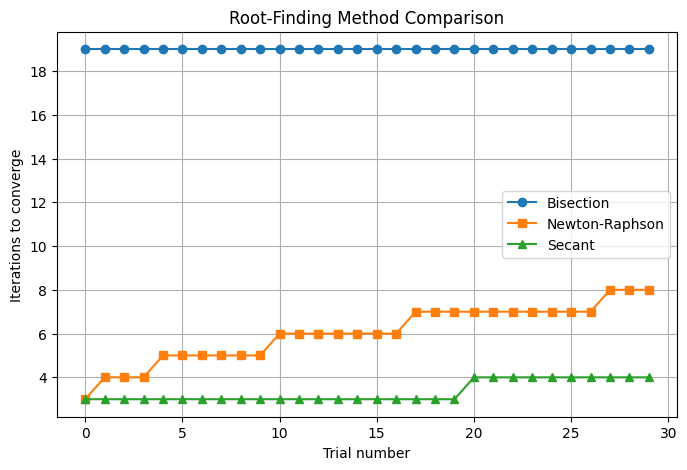

Average iterations:
Bisection: 19.00
Newton:    6.03
Secant:    3.33


In [5]:
def solve_bisection():
    root, iters = bisection(0, 1.0)
    return root, iters, abs(f(root))

def solve_newton(x0):
    root, iters = newton(x0)
    return root, iters, abs(f(root))

def solve_secant(x0, x1):
    root, iters = secant(x0, x1)
    return root, iters, abs(f(root))

n_trials = 30
newton_iters = []
secant_iters = []

# Different initial guesses
x0_values = np.linspace(0.05, 0.9, n_trials)

for x0 in x0_values:
    _, it, res = solve_newton(x0)
    newton_iters.append(it)

    _, it, res = solve_secant(0, x0)
    secant_iters.append(it)

# Bisection only needs interval
bis_iters = []
for _ in range(n_trials):
    _, it, _ = solve_bisection()
    bis_iters.append(it)

plt.figure(figsize=(8,5))

plt.plot(bis_iters, 'o-', label='Bisection')
plt.plot(newton_iters, 's-', label='Newton-Raphson')
plt.plot(secant_iters, '^-', label='Secant')

plt.xlabel('Trial number')
plt.ylabel('Iterations to converge')
plt.title('Root-Finding Method Comparison')
plt.legend()
plt.grid(True)
plt.show()

print("Average iterations:")
print(f"Bisection: {np.mean(bis_iters):.2f}")
print(f"Newton:    {np.mean(newton_iters):.2f}")
print(f"Secant:    {np.mean(secant_iters):.2f}")


basin of convergence for newton


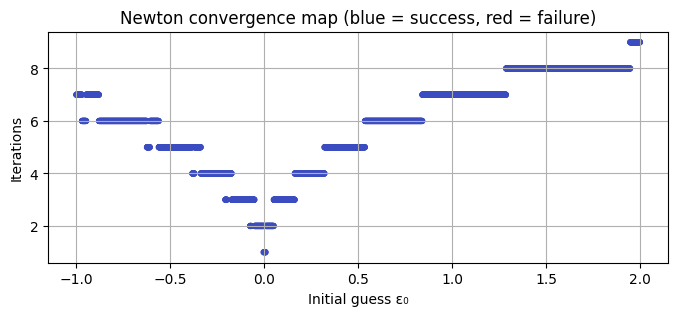

In [8]:
def newton_converges(x0, tol=1e-6, max_iter=500):
    x = x0
    for i in range(max_iter):
        dfx = df(x)
        if abs(dfx) < 1e-6:   # derivative breakdown
            return False, i
        x = x - f(x) / dfx
        if abs(f(x)) < tol:
            return True, i
    return False, max_iter

x0_vals = np.linspace(-1, 2, 4000)

success = []
iters = []

for x0 in x0_vals:
    ok, it = newton_converges(x0)
    success.append(ok)
    iters.append(it)

plt.figure(figsize=(8,3))

plt.scatter(
    x0_vals,
    iters,
    c=success,
    cmap='coolwarm',
    s=12
)

plt.xlabel("Initial guess ε₀")
plt.ylabel("Iterations")
plt.title("Newton convergence map (blue = success, red = failure)")
plt.grid(True)
plt.show()


# Q-3: Reconstructing a Potential Energy Surface


**Problem description:**

You are given noisy force measurements $F(x)$ sampled sparsely.

**Tasks:**

1. Interpolate F(x).
2. Reconstruct the potential V(x) via numerical integration.
3. Identify equilibrium points and classify stability.
4. Make it by two methods
4. Estimate error vs. ground truth
5. Estimate how error behaves with number of intervals for different methods




In [10]:
# Measured x-array

x = np.array([0.99198791, 1.03401624, 1.09777243, 1.16903863, 1.22400793,
       1.30874129, 1.37720132, 1.58423325, 1.64450453, 1.67796538,
       1.67867585, 1.82164472, 1.83116982, 1.84581047, 1.88011411,
       1.8860672 , 2.06462805, 2.22649524, 2.25211675, 2.3344028 ,
       2.36447286, 2.46400053, 2.49198425, 2.49839337, 2.5253077 ,
       2.53460534, 2.55073504, 2.62779939, 2.63802546, 2.70305563,
       2.77555435, 2.84620648, 2.93177044, 2.93846585, 2.94880694])
# Measured force F(x) with noise added

F = np.array([ 3.49692254e+01,  1.18111393e+01,  1.50752617e+00, -1.47634913e+00,
       -2.69134185e+00, -2.54902098e+00, -2.01257802e+00, -7.32708550e-01,
       -6.94759800e-01, -5.97166382e-01, -6.07822394e-01, -4.05705968e-01,
       -3.44239516e-01, -3.57547192e-01, -2.79683457e-01, -2.86210590e-01,
       -1.65878492e-01, -6.50283631e-02, -7.54397513e-02, -5.71115351e-02,
       -5.05335052e-02, -4.08252108e-02, -5.37775421e-02, -3.29453491e-02,
       -4.41318999e-02, -2.53150113e-02, -3.17176381e-02, -2.84810754e-02,
       -3.01711702e-02, -2.61077932e-02, -2.20682730e-02, -1.47373570e-02,
       -1.17158054e-02, -1.50154447e-02, -1.18781079e-02])

Text(0, 0.5, 'F(x)')

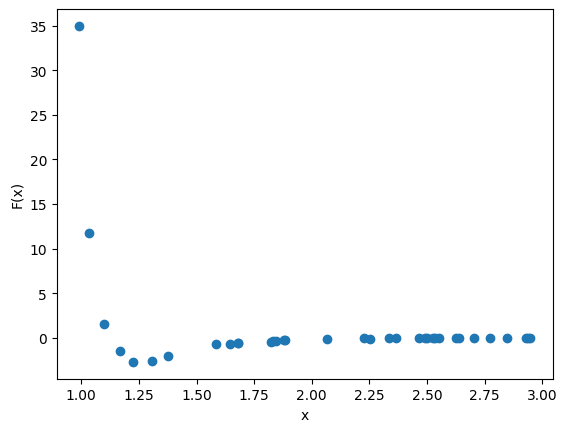

In [11]:
# Visualization

plt.plot(x, F, "o")
plt.xlabel("x")
plt.ylabel("F(x)")

function interpolatio

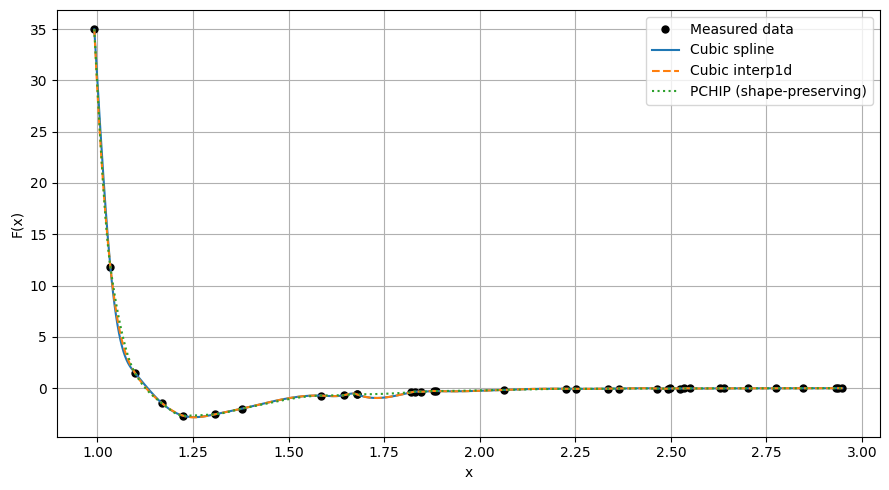

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d, PchipInterpolator



# ----------------------------
# Dense grid for interpolation
# ----------------------------
x_dense = np.linspace(x.min(), x.max(), 1000)

# ----------------------------
# 1. Cubic spline interpolation
# ----------------------------
cs = CubicSpline(x, F, bc_type='natural')
F_spline = cs(x_dense)

# ----------------------------
# 2. Standard cubic interpolation
# ----------------------------
cubic_interp = interp1d(x, F, kind='cubic')
F_cubic = cubic_interp(x_dense)

# ----------------------------
# 3. Shape-preserving cubic (PCHIP)
# ----------------------------
pchip = PchipInterpolator(x, F)
F_pchip = pchip(x_dense)

# ----------------------------
# Plot comparison
# ----------------------------
plt.figure(figsize=(9, 5))
plt.plot(x, F, 'o', color='black', label='Measured data', markersize=5)
plt.plot(x_dense, F_spline, label='Cubic spline')
plt.plot(x_dense, F_cubic, '--', label='Cubic interp1d')
plt.plot(x_dense, F_pchip, ':', label='PCHIP (shape-preserving)')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


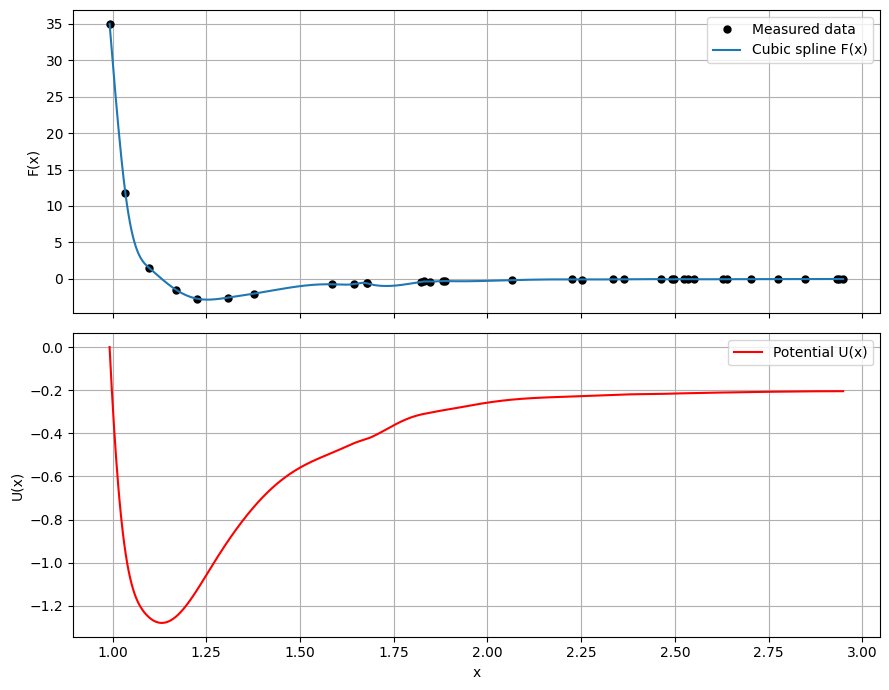

In [13]:
# ----------------------------
# Numerical integration: Force -> Potential
# ----------------------------

# Antiderivative of the spline
U_spline_func = cs.antiderivative()

# Choose reference point for potential
x_ref = x_dense[0]           # left boundary
U_ref = U_spline_func(x_ref)

# Potential energy (U = -∫F dx)
U = -(U_spline_func(x_dense) - U_ref)

# ----------------------------
# Plot Force and Potential
# ----------------------------
fig, ax = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

# Force plot
ax[0].plot(x, F, 'o', color='black', markersize=5, label='Measured data')
ax[0].plot(x_dense, F_spline, label='Cubic spline F(x)')
ax[0].set_ylabel('F(x)')
ax[0].legend()
ax[0].grid(True)

# Potential plot
ax[1].plot(x_dense, U, color='red', label='Potential U(x)')
ax[1].set_xlabel('x')
ax[1].set_ylabel('U(x)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


## Ground-truth for benchmarking and validation

In [15]:
import numpy as np

# ----------------------------
# Lennard–Jones potential + force (ground truth)
# ----------------------------
def lj_potential(r, epsilon=1.0, sigma=1.0):
    """
    V(r) = 4ε[(σ/r)^12 - (σ/r)^6]
    r must be > 0.
    """
    sr6 = (sigma / r) ** 6
    return 4.0 * epsilon * (sr6**2 - sr6)

def lj_force(r, epsilon=1.0, sigma=1.0):
    """
    Force is negative derivative of potential:
      F(r) = -dV/dr = 24ε/r [2(σ/r)^12 - (σ/r)^6]
    Convention: positive F means repulsive (pushing outward).
    """
    sr6 = (sigma / r) ** 6
    sr12 = sr6**2
    return 24.0 * epsilon / r * (2.0 * sr12 - sr6)

# ----------------------------
# Sampling with LogNormal noise
# ----------------------------
def sample_noisy_lj_force(
    n=35,
    r_min=0.9, r_max=3.0,
    epsilon=1.0, sigma=1.0,
    sigma_ln=0.15,
    seed=0
):
    """
    Sample n separations r uniformly in [r_min, r_max].
    Compute ground truth V(r), F(r).
    Add multiplicative LogNormal noise to |F| while preserving sign:
        F_meas = sign(F_true) * |F_true| * LogNormal(0, sigma_ln)

    This avoids sign flips caused by multiplicative noise near zero.
    """
    rng = np.random.default_rng(seed)

    r = rng.uniform(r_min, r_max, size=n)
    r.sort()

    V_true = lj_potential(r, epsilon=epsilon, sigma=sigma)
    F_true = lj_force(r, epsilon=epsilon, sigma=sigma)

    # multiplicative noise factor (median 1)
    noise_factor = rng.lognormal(mean=0.0, sigma=sigma_ln, size=n)

    # apply to magnitude, keep sign
    F_meas = np.sign(F_true) * (np.abs(F_true) * noise_factor)

    return r, V_true, F_true, F_meas

# ----------------------------
# Optional: dense ground-truth curve for plotting / grading
# ----------------------------
def dense_ground_truth(
    r_min=0.9, r_max=3.0, num=800,
    epsilon=1.0, sigma=1.0
):
    r = np.linspace(r_min, r_max, num=num)
    V = lj_potential(r, epsilon=epsilon, sigma=sigma)
    F = lj_force(r, epsilon=epsilon, sigma=sigma)
    return r, V, F

# Example usage:
if __name__ == "__main__":
    eps, sig = 1.0, 1.0
    r_s, V_s, F_true_s, F_meas_s = sample_noisy_lj_force(
        n=35, r_min=0.9, r_max=3.0,
        epsilon=eps, sigma=sig,
        sigma_ln=0.20, seed=42
    )

    print("First 5 sparse samples:")
    for i in range(5):
        print(f"r={r_s[i]:.4f}  V_true={V_s[i]: .5f}  F_true={F_true_s[i]: .5f}  F_meas={F_meas_s[i]: .5f}")

    # Dense ground truth arrays (for plotting / reference)
    r_dense, V_dense, F_dense = dense_ground_truth(
        r_min=0.9, r_max=3.0, num=800,
        epsilon=eps, sigma=sig
    )


First 5 sparse samples:
r=0.9920  V_true= 0.20758  F_true= 27.90132  F_meas= 34.96923
r=1.0340  V_true=-0.59511  F_true= 12.08340  F_meas= 11.81114
r=1.0978  V_true=-0.97962  F_true= 1.78336  F_meas= 1.50753
r=1.1690  V_true=-0.95314  F_true=-1.74102  F_meas=-1.47635
r=1.2240  V_true=-0.83576  F_true=-2.36297  F_meas=-2.69134


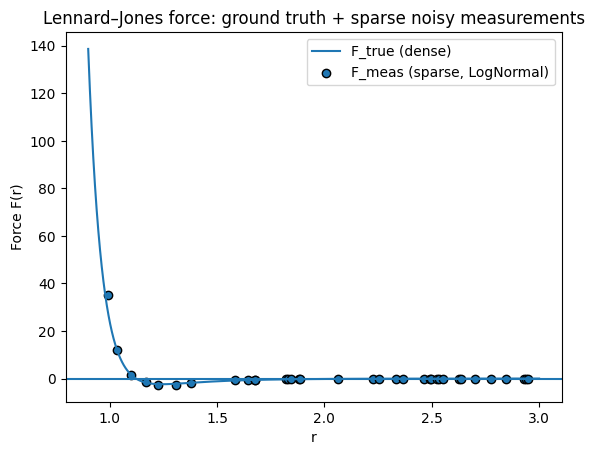

In [16]:
import matplotlib.pyplot as plt

eps, sig = 1.0, 1.0
r_s, V_s, F_true_s, F_meas_s = sample_noisy_lj_force(
    n=35, r_min=0.9, r_max=3.0,
    epsilon=eps, sigma=sig,
    sigma_ln=0.20, seed=42
)
r_dense, V_dense, F_dense = dense_ground_truth(
    r_min=0.9, r_max=3.0, num=800,
    epsilon=eps, sigma=sig
)

plt.figure()
plt.plot(r_dense, F_dense, label="F_true (dense)")
plt.scatter(r_s, F_meas_s, label="F_meas (sparse, LogNormal)", edgecolors="k")
plt.axhline(0.0)
plt.xlabel("r")
plt.ylabel("Force F(r)")
plt.legend()
plt.title("Lennard–Jones force: ground truth + sparse noisy measurements")
plt.show()


# Q-4: Inferring a Hidden Parameter


**Problem description:**

A measurement depends on an unknown parameter $\theta$:

$y(x) = sin(\theta x)\cdot \exp(-x/\theta) + 0.1$

**Tasks:**

1. Analyze the model function and explain how the parameter $\theta$ affects: the oscillation frequency, the decay rate, and the overall signal shape.
2. Interpolate experimental $y(x)$.
3. Use root finding or optimization to infer $\theta$ as a function of control parameter
4. Assess sensitivity to sampling density: calculate the erro vs, number of sampling point





In [ ]:
# Measured x array

x = np.array([0.38290354, 0.56506409, 0.7686818 , 1.36343233, 2.22478815,
       2.63327064, 2.66048519, 2.70231563, 3.32750872, 3.78998639,
       3.86319072, 4.18420817, 4.56683821, 4.64373629, 4.71638583,
       4.93656968, 4.96578703, 5.15158752, 5.56058993, 5.85373411])

In [ ]:
# Measured y array

y = np.array([ 0.90729402,  0.84997623,  0.74311117, -0.50392934,  0.37535527,
        0.46048623,  0.52935328,  0.47794092, -0.15467925, -0.04166709,
        0.19077634,  0.20216884,  0.27753295,  0.22439955,  0.33582051,
        0.25559092,  0.1122858 , -0.07146884, -0.14983466,  0.09501767])

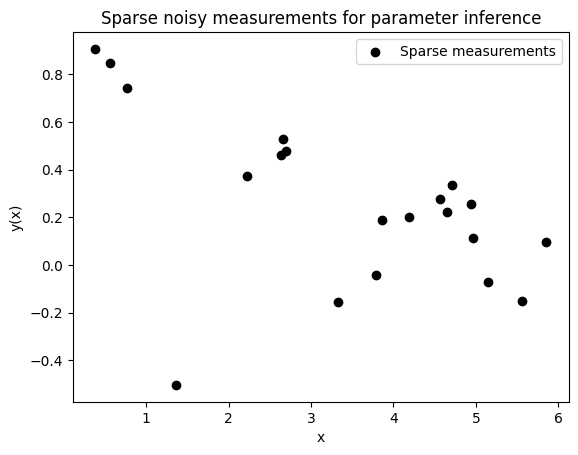

In [ ]:
plt.scatter(x_s, y_meas_s, c="k", label="Sparse measurements")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend()
plt.title("Sparse noisy measurements for parameter inference")
plt.show()

## Ground-truth for comparison

In [ ]:
import numpy as np

# ----------------------------
# Ground-truth model
# ----------------------------
def model_y(x, theta):
    return np.sin(theta * x) * np.exp(-x / theta) + 0.1

# ----------------------------
# Data generation
# ----------------------------
def generate_data(
    theta=3.14,
    n_samples=20,
    x_min=0.0,
    x_max=6.0,
    noise_sigma=0.0,
    seed=0
):
    """
    Generate randomly sampled measurements y(x).

    Parameters
    ----------
    theta : float
        True hidden parameter.
    n_samples : int
        Number of sampling points.
    x_min, x_max : float
        Measurement range.
    noise_sigma : float
        Std dev of additive Gaussian noise (0 = noise-free).
    seed : int
        RNG seed.

    Returns
    -------
    x : ndarray
        Sampled x locations (sorted).
    y_true : ndarray
        Noise-free ground truth values.
    y_meas : ndarray
        Measured values (with noise).
    """
    rng = np.random.default_rng(seed)

    # Random sampling in x
    x = rng.uniform(x_min, x_max, size=n_samples)
    x.sort()

    # Ground truth
    y_true = model_y(x, theta)

    # Optional additive noise
    noise = rng.normal(0.0, noise_sigma, size=n_samples)
    y_meas = y_true + noise

    return x, y_true, y_meas

# ----------------------------
# Example usage
# ----------------------------
if __name__ == "__main__":
    x, y_true, y_meas = generate_data(
        theta=3.14,
        n_samples=20,
        x_min=0.0,
        x_max=6.0,
        noise_sigma=0.1,
        seed=42
    )

    print("First 5 samples:")
    for i in range(5):
        print(f"x = {x[i]:.3f}, y_true = {y_true[i]:.4f}, y_meas = {y_meas[i]:.4f}")


First 5 samples:
x = 0.383, y_true = 0.9258, y_meas = 0.9073
x = 0.565, y_true = 0.9181, y_meas = 0.8500
x = 0.769, y_true = 0.6209, y_meas = 0.7431
x = 1.363, y_true = -0.4885, y_meas = -0.5039
x = 2.225, y_true = 0.4182, y_meas = 0.3754


In [ ]:
def dense_ground_truth(theta=3.14, x_min=0.0, x_max=6.0, n=1000):
    x = np.linspace(x_min, x_max, n)
    y = model_y(x, theta)
    return x, y


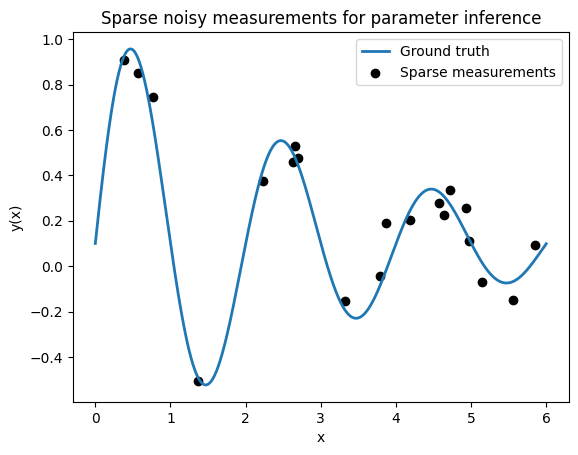

In [ ]:
import matplotlib.pyplot as plt

x_s, y_true_s, y_meas_s = generate_data(
    theta=3.14, n_samples=20, noise_sigma=0.1, seed=42
)
x_dense, y_dense = dense_ground_truth(theta=3.14)

plt.figure()
plt.plot(x_dense, y_dense, label="Ground truth", lw=2)
plt.scatter(x_s, y_meas_s, c="k", label="Sparse measurements")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend()
plt.title("Sparse noisy measurements for parameter inference")
plt.show()
